In [1]:
%%capture install
try:
  import rlmep
  print('Already installed')
except:
  %pip install git+https://github.com/Mads-PeterVC/rlmep

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
%matplotlib inline

# Q-learning

## The 'Frozen Lake'-environment

In [3]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array', is_slippery=False)

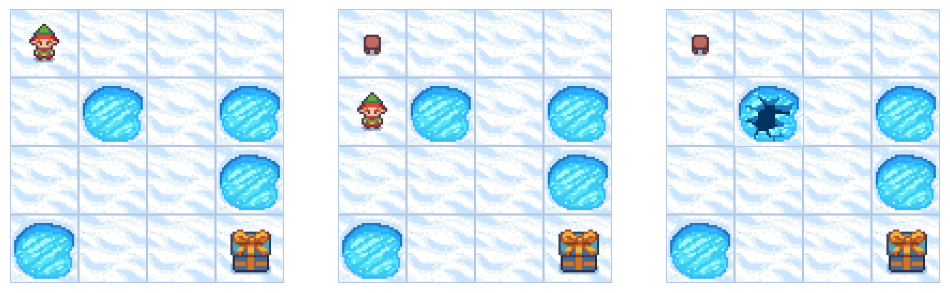

In [4]:
state = env.reset()
sz = 4
fig, ax = plt.subplots(1, 3, figsize=(3*sz, 1*sz))
img = ax[0].imshow(env.render())
_ = env.step(1)
img = ax[1].imshow(env.render())
_ = env.step(2)
img = ax[2].imshow(env.render())

for a in ax.flatten():
    a.axis('off')

In [5]:
# Check if an action is part of the space. 
contains_action = [env.action_space.contains(a) for a in range(5)]
print(f"{env.action_space = }")
print(f"{contains_action = }")

# Sample an action from the space.
sampled_action = env.action_space.sample()
print(f"{sampled_action = }\n")

# The observation space
print(f"{env.observation_space = }")

env.action_space = Discrete(4)
contains_action = [True, True, True, True, False]
sampled_action = np.int64(2)

env.observation_space = Discrete(16)


## Tabular Q-learning


### Temporal difference derivation

Now that we have an environment, the second thing we need is an algorithm. We will be using Q-learning with a table. 

Here Q is the action-value function, from the Bellman equation: 

$$ Q(s_t, a_t) = \mathbb{E}_{s^*} [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s^*, a^*)] $$

The expectation value here is over the possible states resulting from taking action $a$ in state $s$. $\gamma$ is the discount factor, 
it weights the importance of future rewards. 
Given that we have our environment has deterministic transition function we can ignore that expectation value and 
reach the equation

$$ Q(s_t, a_t) = [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s_{t+1}, a^*)] $$

So, for a given state-action pair $(s_t, a_t)$ the Q-value is the sum of the reward and the maximum of the next state. 
Initially we dont know Q, so we will need a learning algorithm. To reach such an algorithm we write an error

$$ [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} Q(s_{t+1}, a^*)] - Q(s_t, a_t) $$

To minimize that, we can update the Q-value according to

$$
\begin{align}
Q(s_t, a_t) &\leftarrow Q(s_t, a_t) + \alpha \left( [r_t + \gamma \mathrm{max}_{a^*} Q(s_{t+1}, a^*)] - Q(s_t, a_t) \right) \\
&= (1-\alpha) Q(s_t, a_t) +  \alpha [r_t + \gamma \mathrm{max}_{a^*} Q(s_{t+1}, a^*)]
\end{align}
$$

Where $\alpha$ is a learning rate parameter, if $\alpha = 1$ we can see that this update rule reduces to just setting 

$$ Q(s_t, a_t) \leftarrow [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s_{t+1}, a^*)] $$

Which is essentially taking the Bellman equation and changing the equals sign to an arrow. 
This is the **temporal difference** target. 

### $\epsilon$-greedy policy

Reinforcement learning often happens in 'episodes' of letting the 'agent'/algorithm explore the environment, gathering 
information and possibly training. Our agent in this case is defined by the Q-table, generally in RL we say that the agent follows a 'policy', in this case our policy will mostly be to choose actions according to $\mathrm{argmax}(Q(s, a))$. In order to have some exploration of the environment we will modify this greedy strategy, leading us to a so-called $\epsilon$-greedy policy. 

It goes as follows: 
- Draw some random number $z$
- If $z < \epsilon$ draw a random action. 
- Else choose according to $\mathrm{argmax} \ Q(s, s)$

### Algorithm

Now we have all the elements required for our algorithm, so lets put it together. 

Our algorithm will thus be as follows: 

- Create a Q-table of just zeros of size (16, 4)

1. Choose an action according to the $\epsilon$-greedy strategy. 
2. Take a step in the environment with that action, resulting in the next state, reward and a signal of whether the state is terminal or not. 
3. Update the Q-value according to the temporal difference rule from above. 
4. If the action lead to a terminal state end the episode. 

In [ ]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array', is_slippery=False)
Q_table = np.zeros((16, 4), dtype=np.float64)

# Hyperparameters
epsilon = 0.5
learning_rate = 1
gamma = 0.9
num_episodes = 250


for episode in tqdm(range(num_episodes)):

    state, _ = env.reset()
    terminal = False
    truncated = False

    while not terminal and not truncated:
        # Choose action
        # If random number is less than epsilon, then select a random action
        # Else select according to the Q-values. When selecting according to Q-values,
        # if all actions have the same Q-value, then select a random action.
        # This is done as argmax will always select the first index in the case of a tie.
        if np.random.rand() < epsilon:
            action = np.random.randint(0, 4)
        else:
            if (Q_table[state, :] == Q_table[state, 0]).all():
                action = np.random.randint(0, 4)
            else:
                action = np.argmax(Q_table[state])

        # Take action by calling env.step
        next_state, reward, terminal, truncated, info = env.step(action)

        # Calculate Q-target
        # Q_target = reward + gamma * np.max(Q_table[next_state, :]) - Q_table[state, action]
        if not terminal:
            Q_target = reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action]
        else:
            Q_target = reward - Q_table[state, action]

        # Update Q-table
        Q_table[state, action] += learning_rate * Q_target

        state = next_state

100%|██████████| 250/250 [00:00<00:00, 15564.67it/s]


In order to figure out whether things are working, the following cell will plot the Q-values learned by your agent. 

The figure shows the learned Q-values for each action of each state, if any of the Q-values differ from zero. 
To understand from the visualization whether your implementation is working or not, you should consider the 
following questions;

- What should the Q-value be for state-action pairs that lead to the goal be? 
- What should Q-values for state-actions pairs that lead to hole tiles be? 
- How should the Q-values depend on the discount factor $\gamma$? 
- What should the Q-values for illegal actions be? (E.g. actions that attempt to move the adventurer out of the grid.) 

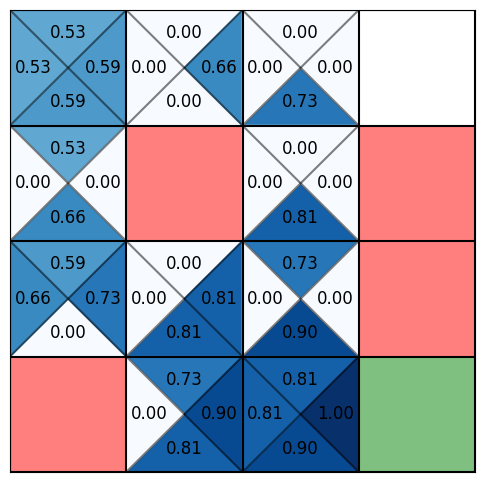

: 

In [ ]:
from rlmep import plot_qvalues

plot_qvalues(Q_table, env=env)